# Predictive Maintenance — AI4I 2020 (Machine Failure Prediction)

**Goal:** Predict whether a machine will fail (binary classification) using sensor and operating condition features from the AI4I 2020 Predictive Maintenance dataset.

**Models:** Logistic Regression (interpretable baseline) and Random Forest (non‑linear model)

**Key topics covered:** EDA, preprocessing (one‑hot encoding + scaling), class imbalance handling, threshold tuning (PR curve / F1), model evaluation (confusion matrix, ROC‑AUC, PR‑AUC), and feature interpretation.

> **Note on data file:** place `ai4i2020.csv` inside a folder named `data/` next to this notebook, then run the notebook.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import(accuracy_score,
                            confusion_matrix,
                            classification_report,
                            roc_curve,
                            roc_auc_score,
                            precision_score,
                            recall_score,
                            f1_score)
plt.style.use('ggplot')


#Predictive Maintenance — AI4I 2020 Dataset


In [16]:
df = pd.read_csv('/content/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


## 2. Data Exploration (EDA)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [18]:
df.isna().sum()

,0
UDI,0
Product ID,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Machine failure,0
TWF,0


In [19]:
df['Machine failure'].value_counts()

,count
Machine failure,
0,9661
1,339


In [20]:
df['Machine failure'].value_counts(normalize=True)

,proportion
Machine failure,
0,0.9661
1,0.0339


In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


# ✅ EDA  3 — Separate numeric and categorical *columns*

In [22]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols =df.select_dtypes(include=["object"]).columns.tolist()

In [23]:
numeric_cols

['UDI',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Machine failure',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [24]:
cat_cols

['Product ID', 'Type']

# ✅ EDA 4 — Failure rate by product type (important)

In [25]:
if "Type" in df.columns :
  churn_by_type = df.groupby("Type")["Machine failure"].mean().sort_values(ascending=False)
  display(churn_by_type)

,Machine failure
Type,
L,0.039167
M,0.027694
H,0.020937


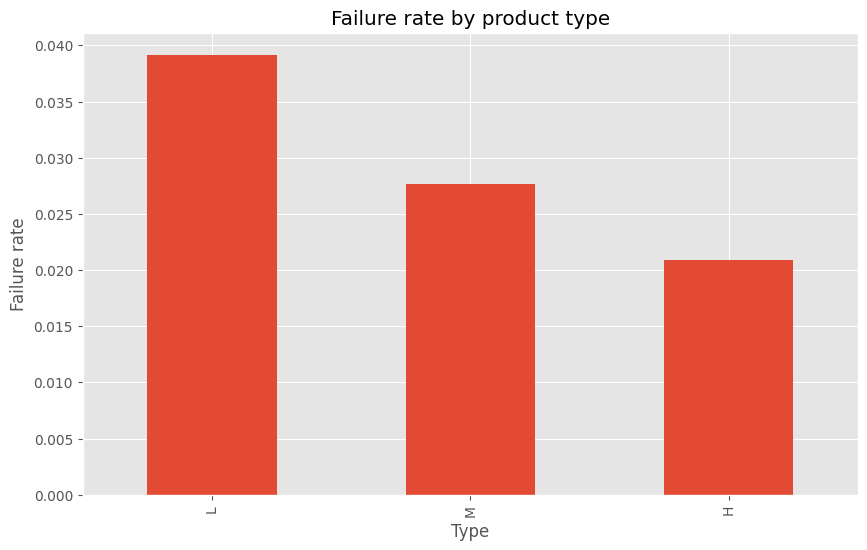

In [26]:
churn_by_type.plot(kind="bar", figsize=(10,6))
plt.ylabel("Failure rate")
plt.title("Failure rate by product type")
plt.show()

# ✅ 5 — Histograms of sensor features (overall)

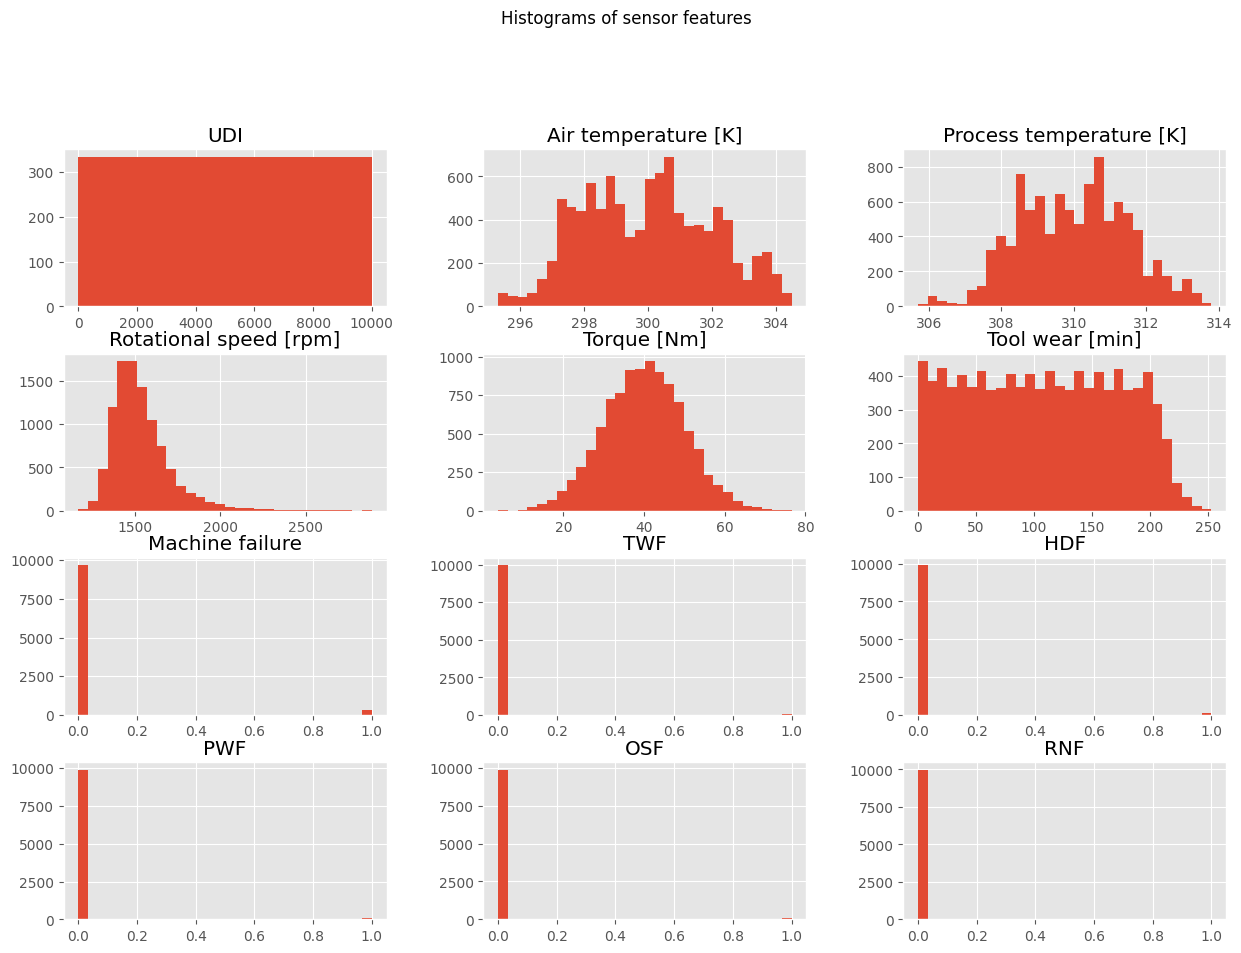

In [27]:
df[numeric_cols].hist(figsize=(15,10), bins=30)
plt.suptitle("Histograms of sensor features", y=1.02)
plt.show()

# ✅ EDA 6 — Compare sensor distributions: failure vs no-failure

In [28]:
failure_df = df[df["Machine failure"] == 1]
nonfailure_df = df[df["Machine failure"] == 0]

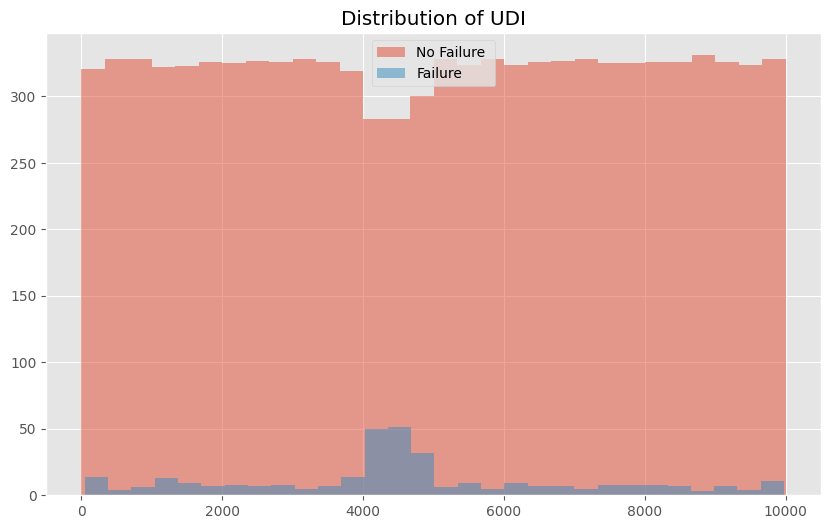

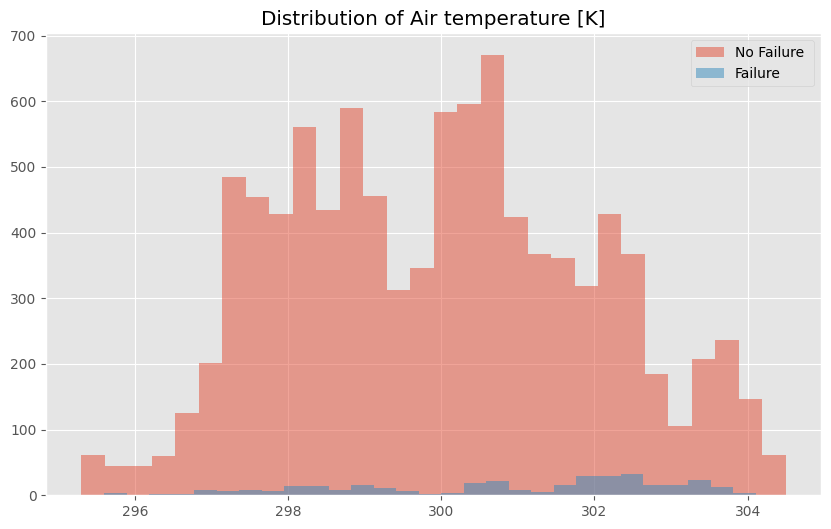

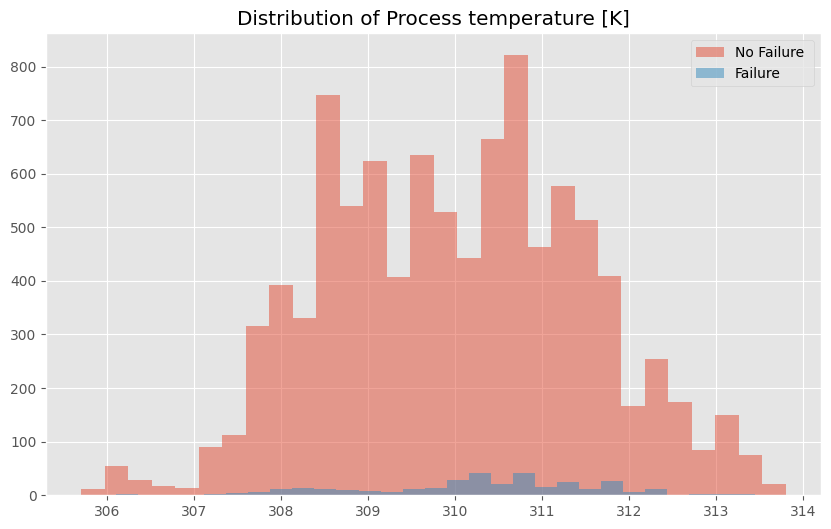

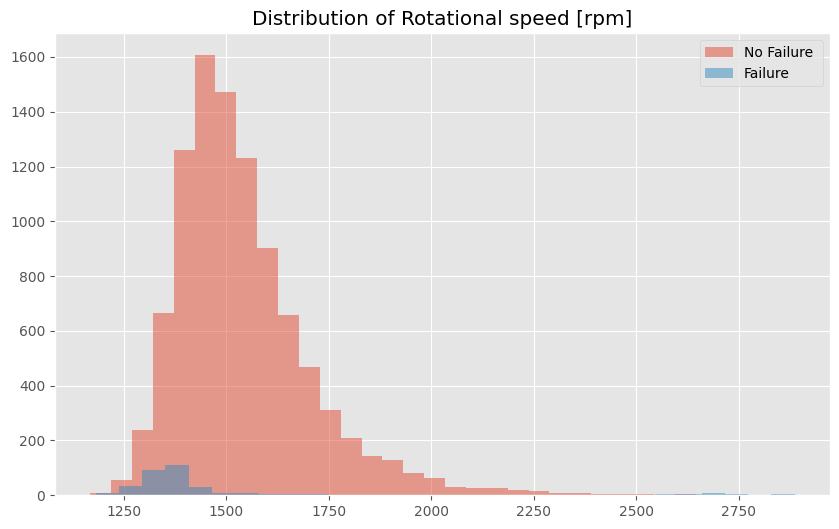

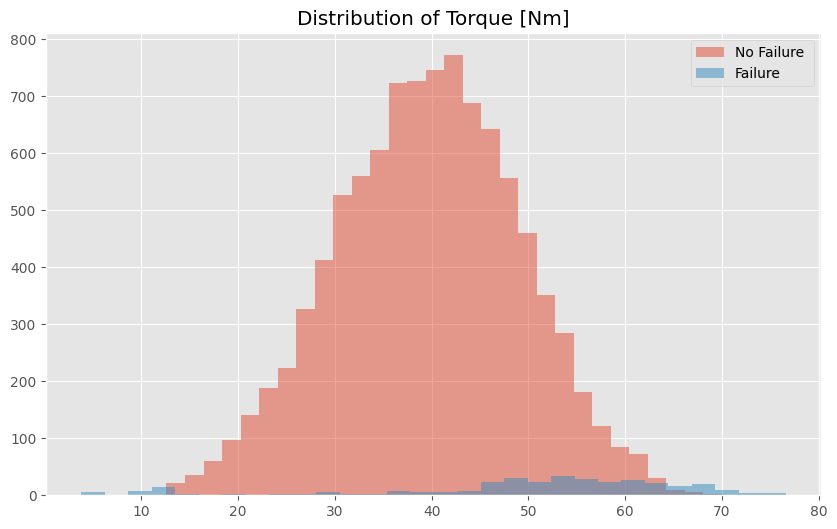

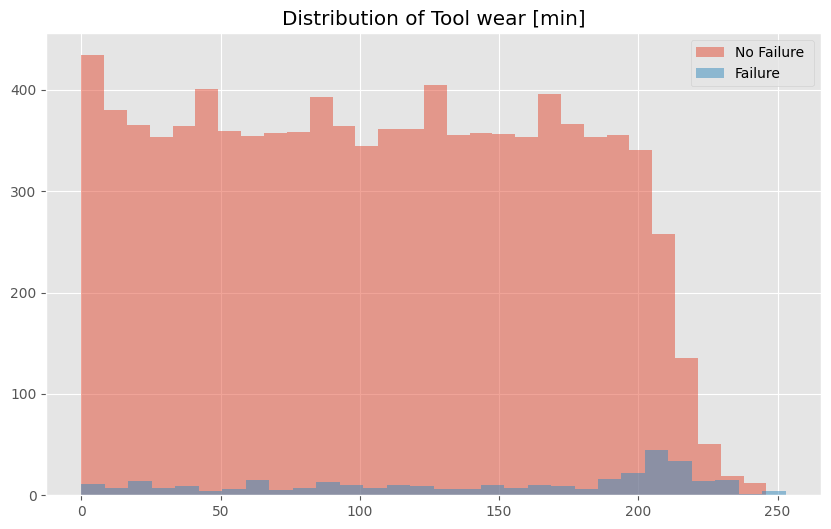

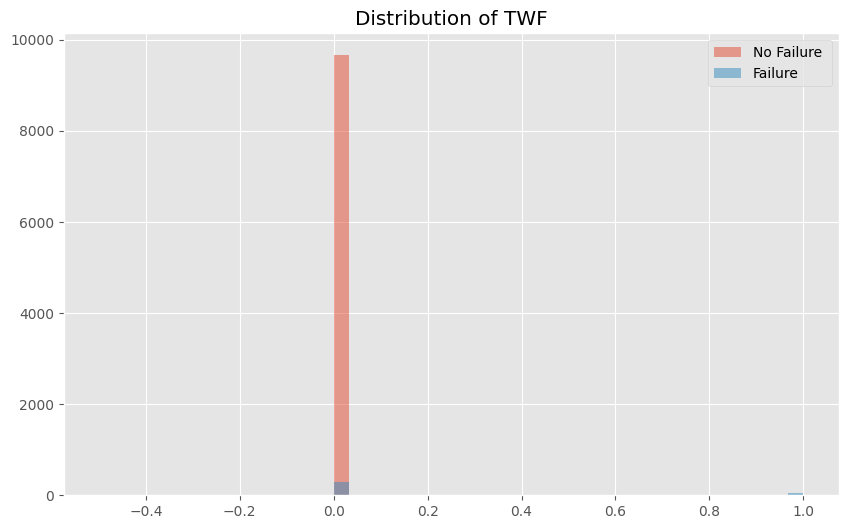

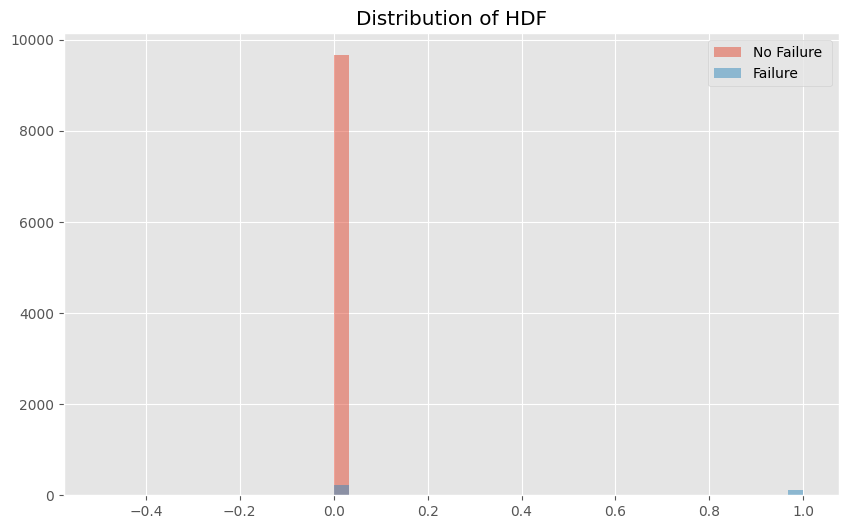

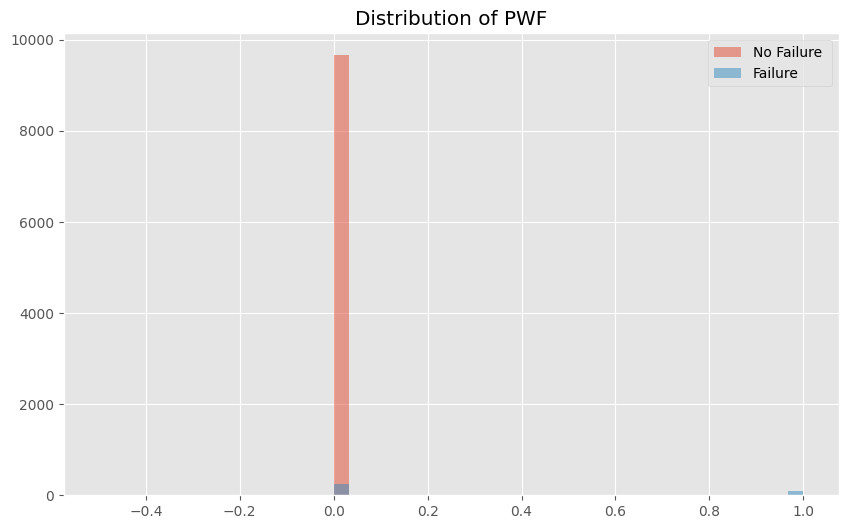

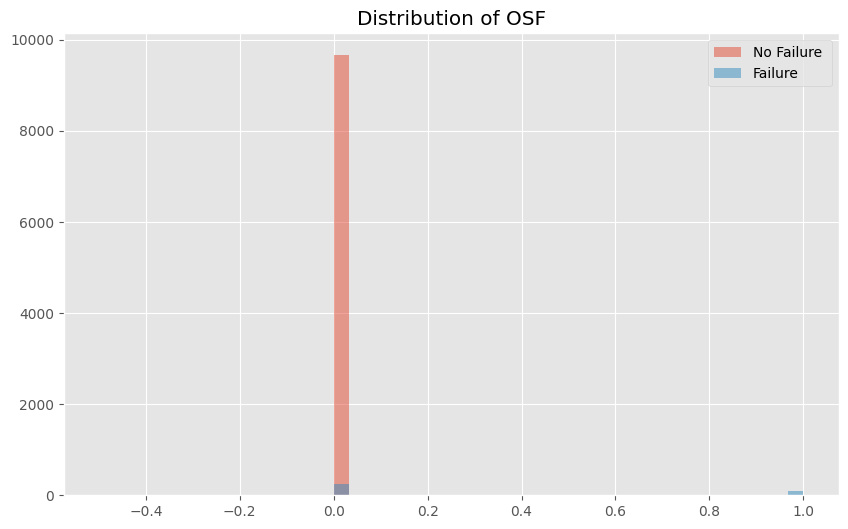

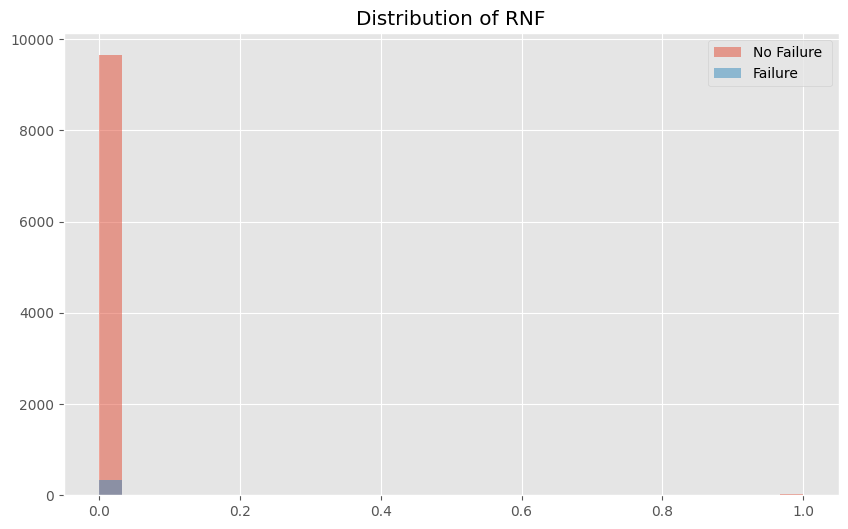

In [29]:
for col in numeric_cols:
  if col == "Machine failure":
    continue
  plt.figure(figsize=(10,6))
  plt.hist(nonfailure_df[col], bins=30, alpha=0.5, label="No Failure ")
  plt.hist(failure_df[col], bins=30, alpha=0.5, label="Failure")
  plt.title(f"Distribution of {col}")
  plt.legend()
  plt.show()

# ✅ EDA Cell 7 — Boxplots by failure class (clean visual)

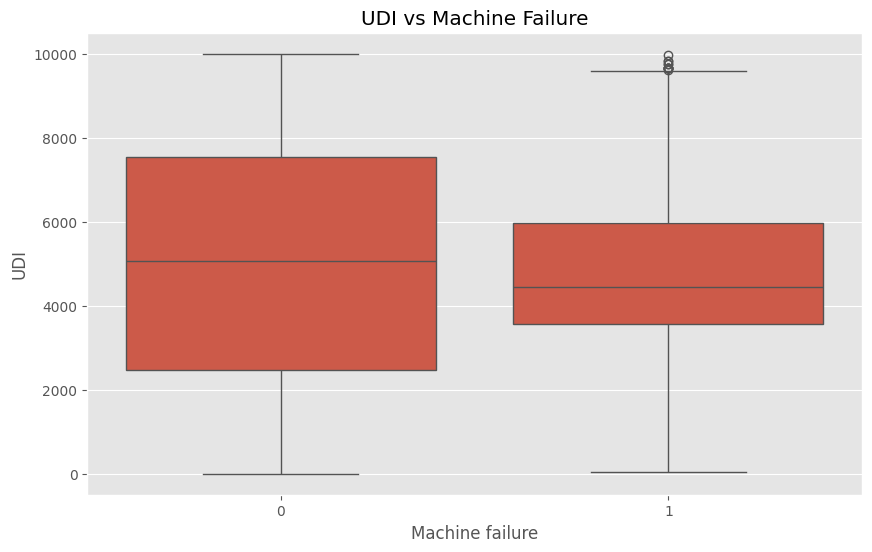

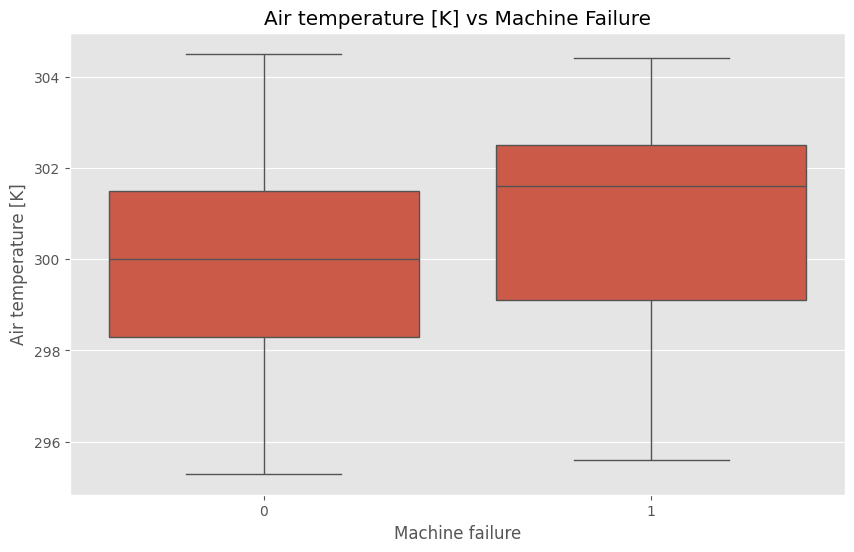

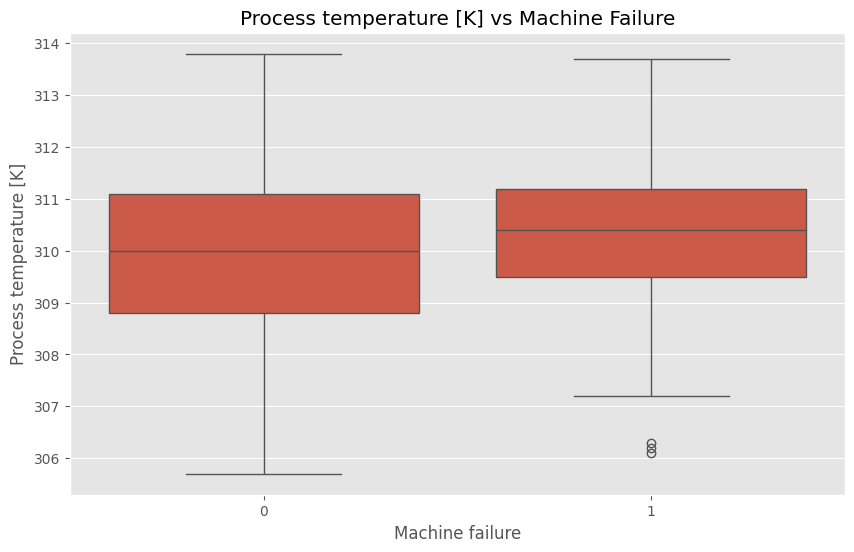

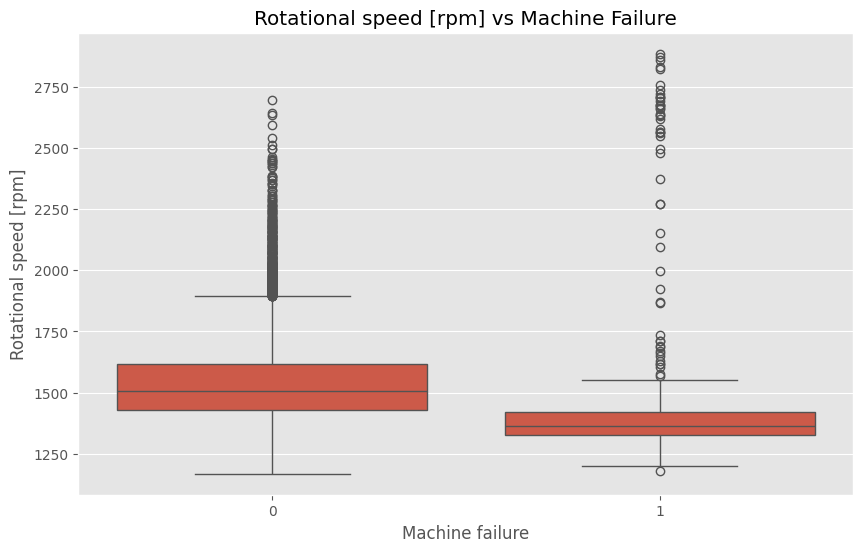

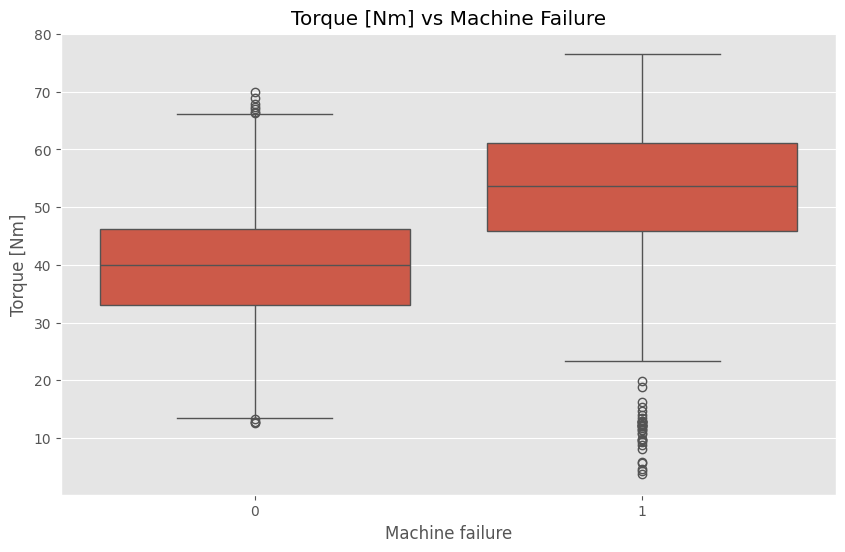

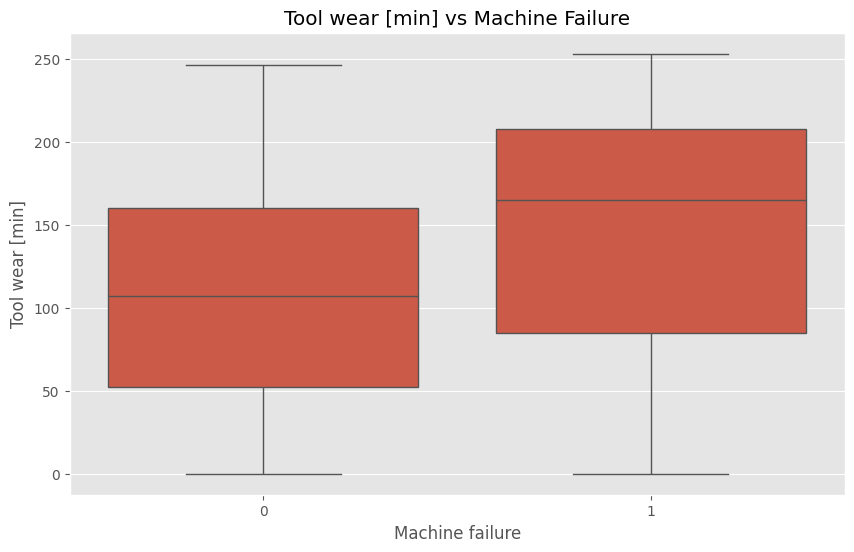

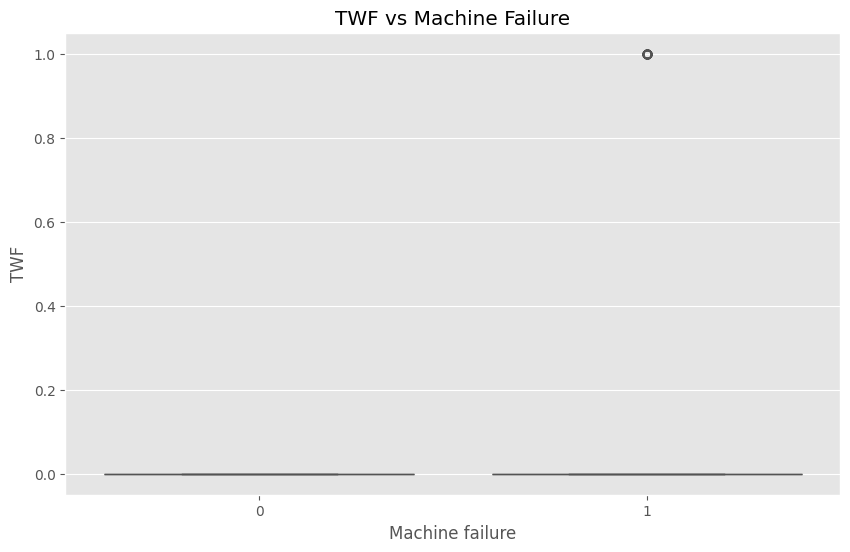

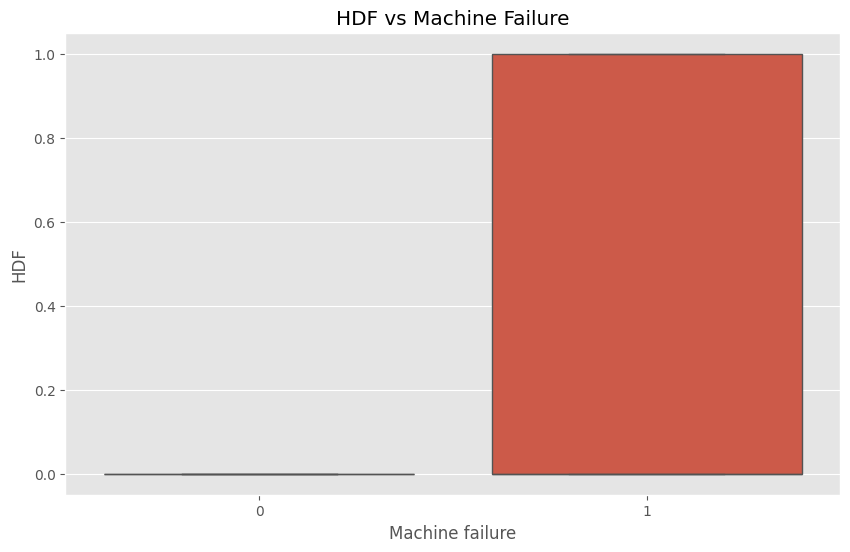

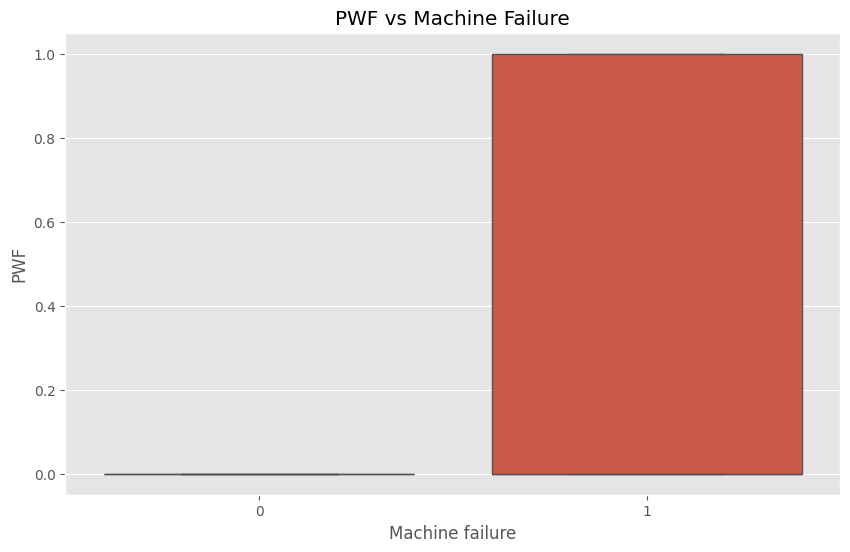

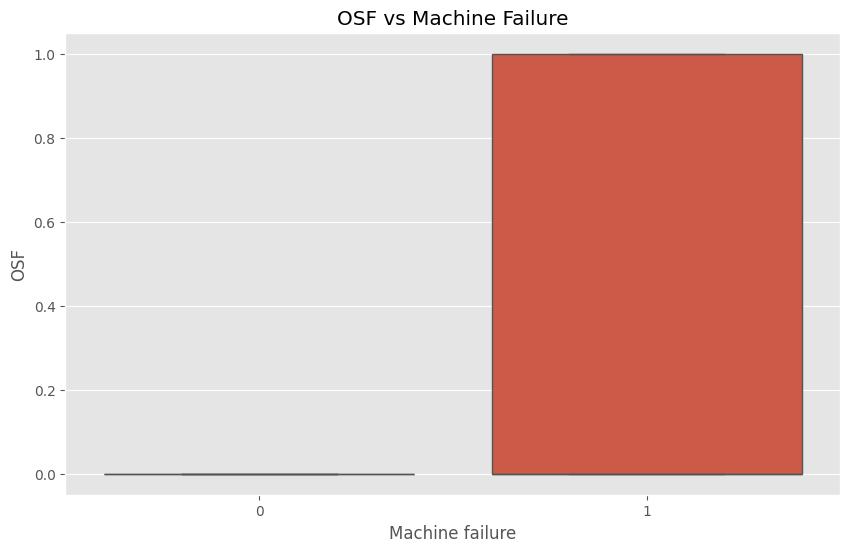

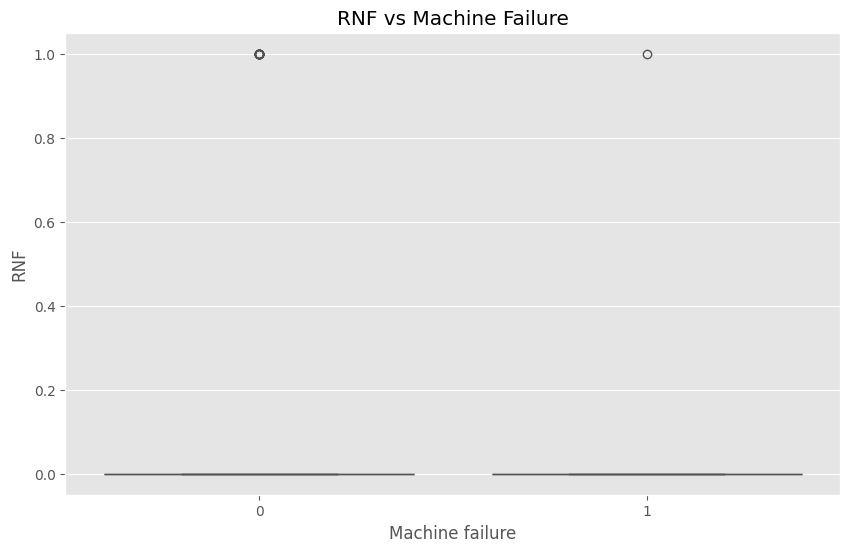

In [30]:
for col in numeric_cols:
  if col == "Machine failure":
    continue
  plt.figure(figsize=(10,6))
  sns.boxplot(x="Machine failure", y=col, data=df)
  plt.title(f"{col} vs Machine Failure")
  plt.show()


# ✅ EDA Cell 8 — Correlation heatmap (numeric only)

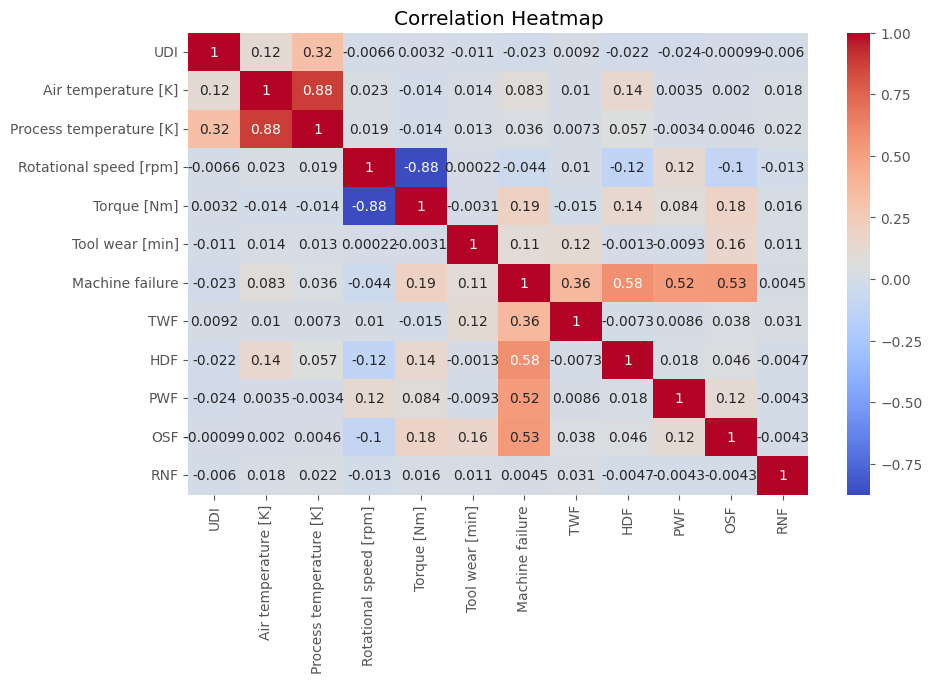

In [31]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [32]:
failure_mode_cols = [c for c in df.columns if c in ["TWF","HDF","PWF","OSF","RNF"]]
failure_mode_cols


['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [33]:
df[failure_mode_cols].sum().sort_values(ascending=False)


,0
HDF,115
OSF,98
PWF,95
TWF,46
RNF,19


# step 2 : Define X and  Y

In [34]:
X = df.drop(columns=['Machine failure'])
y = df['Machine failure']

In [35]:
X.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0


In [49]:
y.head()

,Machine failure
0,0
1,0
2,0
3,0
4,0


# ✅ 7️ Step 3: Preprocessing

In [36]:
df = df.copy()

In [37]:
targget_col = "Machine failure"
print("Target distribution:")
print(df[targget_col].value_counts(normalize=True))

Target distribution:
Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


In [38]:
X = df.drop(columns=[targget_col])
y = df[targget_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10000, 13)
y shape: (10000,)


In [39]:
# These columns don’t help prediction (they’re just identifiers).
id_cols = ["UDI", "Product ID"]
cols_to_drop = [c for c in id_cols if c in X.columns]
print("Columns to drop:", cols_to_drop)
X = X.drop(columns=cols_to_drop)

Columns to drop: ['UDI', 'Product ID']


In [50]:
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

Categorical columns: ['Type']
Numerical columns: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


# One hot encode categorical columns

In [51]:
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print("Before shape:", X.shape)
print("After encoding:", X_encoded.shape)
X_encoded.head()

Before shape: (10000, 11)
After encoding: (10000, 12)


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,True,False
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,True,False
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,True,False
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,True,False


# Train-test split (stratified)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("\nTrain target %:\n", y_train.value_counts(normalize=True).round(4))
print("\nTest target %:\n", y_test.value_counts(normalize=True).round(4))

Train: (8000, 12) Test: (2000, 12)

Train target %:
 Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64

Test target %:
 Machine failure
0    0.966
1    0.034
Name: proportion, dtype: float64


In [57]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)


Scaled train shape: (8000, 12)
Scaled test shape: (2000, 12)


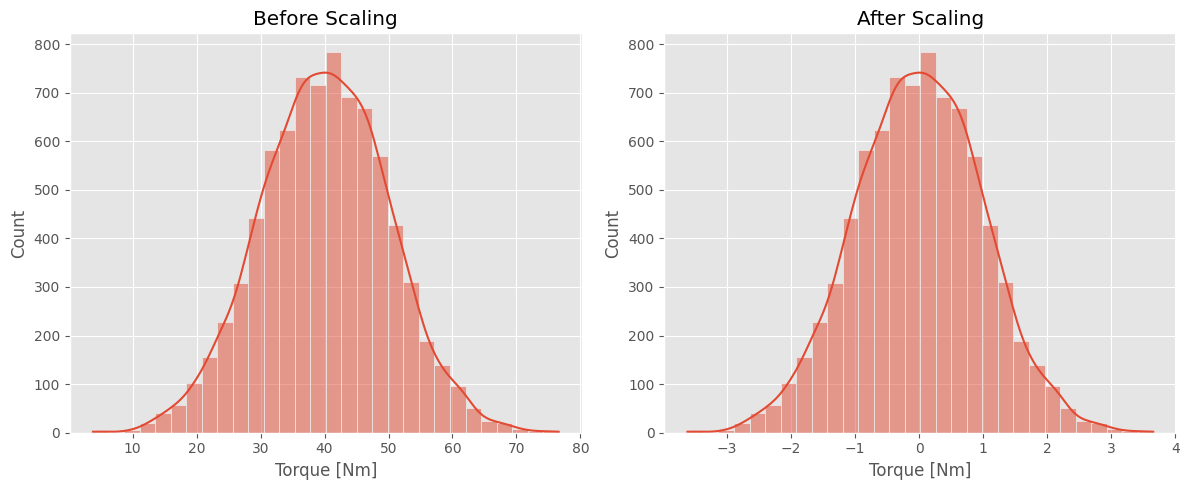

In [63]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

feature = "Torque [Nm]"

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(X_train[feature], bins=30, kde=True)
plt.title("Before Scaling")

plt.subplot(1,2,2)
sns.histplot(X_train_scaled_df[feature], bins=30, kde=True)
plt.title("After Scaling")

plt.tight_layout()
plt.show()

In [64]:
feature_names = X_train.columns.tolist()
print("Number of features:", len(feature_names))
feature_names[:10]


Number of features: 12


['Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'TWF',
 'HDF',
 'PWF',
 'OSF',
 'RNF']

In [65]:
model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight="balanced"
)
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [66]:
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC-AUC: 0.9725672877846792


# ✅ 1️ Confusion Matrix Plot

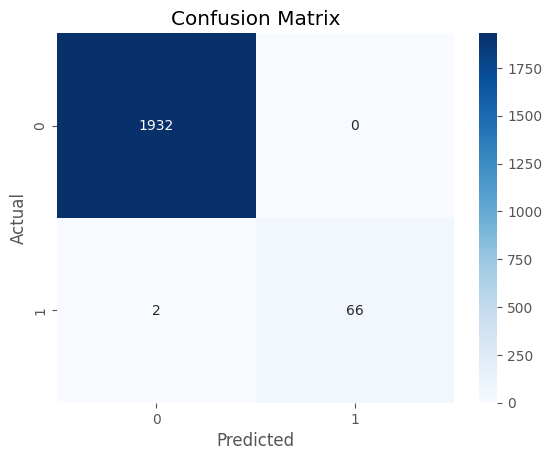

In [47]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


🔎 What Each Number Means
🔵 Top Left (1932) → True Negatives (TN)

1932 healthy machines

Correctly predicted as healthy

No false alarms

🔵 Top Right (0) → False Positives (FP)

Predicted failure

But actually healthy

You have 0

No unnecessary inspections

🔵 Bottom Left (2) → False Negatives (FN)

Actual failure

But predicted healthy

You missed 2 failures

⚠️ In predictive maintenance, this is the most critical error.

🔵 Bottom Right (66) → True Positives (TP)

Actual failure

Correctly detected

66 machines saved

🎯 What This Means

Out of 68 real failures:

You detected 66

You missed 2

Recall =

66
66
+
2
=
0.97
66+2
66
	​

=0.97

Very strong.

🧠 Business Interpretation

If each machine failure costs $50,000:

You prevented:

66
×
50
,
000
=
3.3
𝑀
66×50,000=3.3M

But missed:

2
×
50
,
000
=
100
𝐾
2×50,000=100K

So the model is highly effective.

In [69]:
# 👉 These increase machine failure probability.
coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_[0],
    "Odds_Ratio": np.exp(model.coef_[0])
}).sort_values(by="Odds_Ratio", ascending=False)

coef_df.head(10)


,Feature,Coefficient,Odds_Ratio
7,PWF,1.443390,4.235027
8,OSF,1.324904,3.761824
6,HDF,1.237805,3.448038
5,TWF,0.932296,2.540336
0,Air temperature [K],0.847489,2.333778
3,Torque [Nm],0.172720,1.188534
11,Type_M,0.096747,1.101581
9,RNF,-0.115829,0.890628
4,Tool wear [min],-0.129935,0.878152
2,Rotational speed [rpm],-0.220436,0.802169


| Odds Ratio | Meaning              |
| ---------- | -------------------- |
| > 1        | Increases failure 🔴 |
| < 1        | Reduces failure 🟢   |
| = 1        | No effect            |


Logistic regression revealed that machine failures are primarily driven by discrete failure modes (PWF, OSF, HDF, TWF) rather than continuous sensor readings like RPM or torque. Sensor values act as secondary indicators, while failure flags dominate prediction.

In [70]:
threshold = 0.30
high_risk_machines = (y_prob >= threshold).sum()

high_risk_machines


np.int64(66)

PR-AUC (Average Precision): 0.9716518071303855


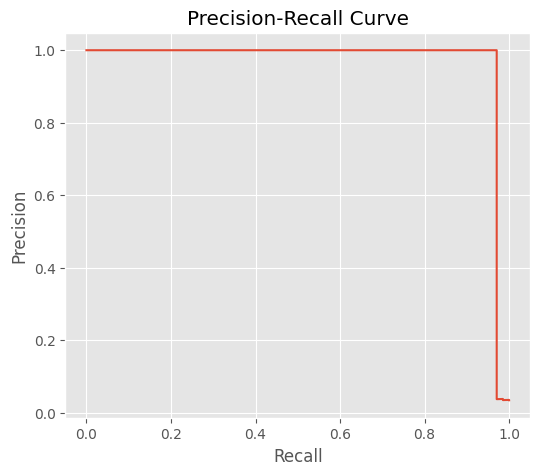

In [71]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("PR-AUC (Average Precision):", pr_auc)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


🚨 Trade-Off

If you lower threshold:

Recall ↑ (you catch more failures)

Precision ↓ (more false alarms)

If you raise threshold:

Precision ↑

Recall ↓ (you miss failures)

In [72]:
import numpy as np

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores[:-1])   # thresholds length is one less
best_threshold = thresholds[best_idx]

print("Best threshold (F1):", best_threshold)
print("Best F1:", f1_scores[best_idx])


Best threshold (F1): 0.9992452163759382
Best F1: 0.9850746263657829


In [73]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_best = (y_prob >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_best))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

Confusion matrix:
 [[1932    0]
 [   2   66]]


# 🌲 You Trained Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample"
)
rf.fit(X_train, y_train)   # trees do NOT need scaling

rf_prob = rf.predict_proba(X_test)[:, 1]

print("RF ROC-AUC:", roc_auc_score(y_test, rf_prob))
print("RF PR-AUC:", average_precision_score(y_test, rf_prob))


RF ROC-AUC: 0.9906071124101815
RF PR-AUC: 0.9768166894664844


## 9. Conclusion


Good. Let’s slow down and make this **very simple**.

You trained **Random Forest** and got:

```
RF ROC-AUC: 0.9906
RF PR-AUC:  0.9768
```

You’re asking:
👉 *What does this actually mean?*

---

# 🎯 1️⃣ ROC-AUC = 0.99

ROC-AUC measures:

> How well the model separates failure vs non-failure.

Value range:

* 0.5 → random guessing
* 0.7 → decent
* 0.8 → good
* 0.9 → excellent
* 1.0 → perfect

Your result:

```
0.99
```

That means:

👉 The model almost perfectly separates failures from healthy machines.

If you randomly pick:

* 1 failed machine
* 1 healthy machine

The model will rank the failed one higher **99% of the time**.

That is extremely strong.

---

# 🎯 2️⃣ PR-AUC = 0.976

This is even more important.

Your dataset is imbalanced:

* 96.6% healthy
* 3.4% failure

PR-AUC measures:

> How good the model is at finding failures without too many false alarms.

Value range:

* 0.03 → random (because only 3% failures)
* 0.5 → good
* 0.8 → very good
* 0.97 → extremely strong

Your result:

```
0.976
```

That means:

👉 The model is very good at detecting failures
👉 While keeping precision high

---

# 🧠 What This Means in Real Life

Your model can:

* Detect failures accurately
* Not raise too many false alarms
* Separate risky machines clearly

That is what predictive maintenance wants.

---

# ⚠️ But Important Warning

Your dataset includes:

* PWF
* OSF
* HDF
* TWF

These are almost direct failure indicators.

That’s why performance is so high.

If you remove those features:

Performance will drop — but it will be more realistic.

---

# 🟢 Simple Final Interpretation

Your Random Forest model is:

✅ Extremely strong
✅ Very accurate
✅ Very good at detecting failures

---

Now let me ask you something important:

If PR-AUC is high but ROC-AUC is average,

Which one should you trust more in imbalanced problems?


## Conclusion

- The dataset is **imbalanced** (failures are rare), so metrics like **Recall**, **PR‑AUC**, and **threshold tuning** matter.
- Logistic Regression provides interpretability (coefficients / odds ratios).
- Random Forest can capture non‑linear patterns and interactions.
- For real-world deployment, validate carefully for **data leakage** (e.g., failure-type flags) and choose a threshold that matches business costs (missed failures vs. false alarms).
